<h1 align="center"> k Neighrest Neighbour : k vecinos más cercanos </h1>

<h2 align="center"> MEA - 2021 

Docente: José I. Robledo </h2>

In [1]:
# Cabecera
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

El objetivo de esta jupyter notebook es tomar intuición acerca del funcionamiento del algoritmo de k vecinos más cercanos (kNN). Este algoritmo es un método no paramétrico de clasificación, es decir donde no asumimos ninguna distribución subyacente en los datos. 

La letra *k* en nombre del método es un número entero que indica la cantidad de vecinos seleccionados. Si $k=1$, entonces el algoritmo se conoce como el del vecino más cercano, el cual sería el caso más simple. Supongamos que tenemos datos en dos dimensiones pertenecientes a dos clases A (rojo) y B (verde) y un dato $x$ que queremos predecir a qué clase pertenece:

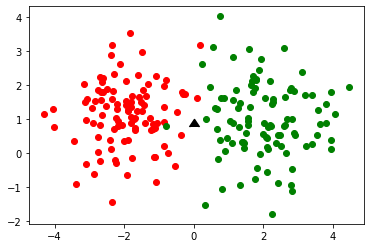

In [2]:
# Clases A y B
rng = np.random.RandomState(1)

A = np.array([rng.normal(-2, 1, 100),
              rng.normal(1, 1, 100)])

B = np.array([rng.normal(2, 1, 100),
              rng.normal(1, 1, 100)])

# Punto a predecir
x = (0, 1)

plt.scatter(*A, c='red')
plt.scatter(*B, c='green')
plt.scatter(*x, c='black', s=100, marker=6)
plt.show()

Los pasos del algoritmo kNN son los siguientes: 

-  El clasificador basado en el método kNN calcula alguna medida de distancia (normalmente la euclídea, pero puede ser la de Hamming, Manhattan, Minkowski, etc.) para encontrar los k vecinos más cercanos al punto a predecir. 

- Luego cuenta cuántos corresponden a cada clase.

- La clase más votada será la clase predicha por el algoritmo.    

Lo "malo" de este algoritmo, es que para encontrar los k vecinos más cercanos debe calcular las distancias a todos los puntos del conjunto de datos y luego ordenarlos de menor a mayor distancia para quedarse con los primeros k. Esto, a medida que la base de datos aumenta en $n$ y a su vez en dimensión $p$ se vuelve computacionalmente muy costo y lento. 

Vamos a hacerlo a mano para ver cómo funciona y luego vamos a ver la implementación de `scikit-learn`.

Primero definimos dos funciones, una que calcula la distancia euclídea y otra que encuentra los $k$ vecinos más cercanos a $x$ entre los puntos pertenecientes a los $datos$. Existen miles de maneras de hacer esto. Este ejemplo es de carácter didáctico.

In [3]:
def distancia_euclidea(x,y):
    '''Calcula la distancia euclídea del vector x'''
    return np.sqrt(sum([(xi - yi)**2 for xi, yi in zip(x,y)]))

def encontrar_k_vecinos(x, datos, k=3):
    '''Devuelve el índice de los k vecinos más cercanos'''
    distancia = [distancia_euclidea(x, dato) for dato in datos]
    primeros_vecinos = np.argsort(distancia)
    return primeros_vecinos[:k]
        

Deberemos juntar los datos de $A$ y $B$ dentro de un único conjunto de datos llamado "data". Luego utilizaremos la función `encontrar_k_vecinos()` con $k=10$ para encontrar los 10 puntos más cercanos a $x$. Tener en cuenta que hemos armado la función `encontrar_k_vecinos()` de manera tal que lo que nos devuelve es una array que contiene los índices en la base $data$ de los primeros $k$ vecinos a $x$. 

In [4]:
%%time
data = np.concatenate([A,B],axis=1).T
indice_de_k_vecinos = encontrar_k_vecinos(x, data, k=10)
indice_de_k_vecinos

Wall time: 2 ms


array([106,  67,   0,  47, 143, 104, 111,   6,  43, 152], dtype=int64)

Por lo tanto, para obtener los puntos en el gráfico, deberemos obtener las coordenadas que corresponde a cada índice de la siguiente manera: 

In [5]:
k_vecinos = np.array([data[i] for i in indice_de_k_vecinos]).T
k_vecinos

array([[ 0.34927873, -0.48018318, -0.37565464,  0.10025514,  0.60337958,
         0.66804833,  0.65732421, -0.25518824, -0.3075454 , -0.793085  ],
       [ 1.01335268,  1.2135339 ,  0.55287144,  1.61838026,  1.32352735,
         0.72090228,  1.30526704,  1.74055645,  1.75041164,  0.80494266]])

Estos los podemos graficar para ver que efectivamente encontramos los 10 puntos más cercanos.

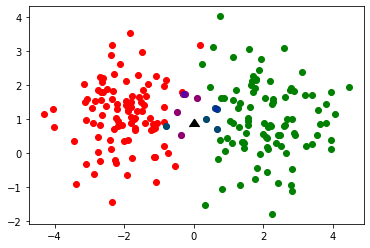

In [6]:
# Clases A y B
rng = np.random.RandomState(1)

A = np.array([rng.normal(-2, 1, 100),
              rng.normal(1, 1, 100)])

B = np.array([rng.normal(2, 1, 100),
              rng.normal(1, 1, 100)])

plt.scatter(*A, c='red')
plt.scatter(*B, c='green')
plt.scatter(*x, c='black', s=100, marker=6)

# Graficamos los k vecinos más cercanos
plt.scatter(*k_vecinos, c='blue', alpha=0.4)

plt.show()

Ahora, podemos armar una función para predecir la etiqueta del punto $x$ en cuestión. Para esto, debe contar entre los $k$ vecinos más cercanos, cuántos eran A y cuántos eran B y luego votar la etiqueta mayoritaria. Si la etiqueta predicha es 'grupo A' podemos pedirle que nos devuelva un 0 y si la etiqueta es 'grupo B' entonces que devuelva 1 :

In [7]:
def predecir_etiqueta(indices):
    '''Realiza la votación de clases'''
    n_clase_A = 0
    n_clase_B = 0
    for i in indices:
        if i <= 100:
            n_clase_A += 1
        else:
            n_clase_B += 1
    
    if n_clase_A >= n_clase_B:
        return 0
    else:
        return 1       

Como venimos haciendo en los ejercicios anteriores, podemos armar una grilla de puntos y predecir en cada punto la clasificación para poder visualizar la frontera de clasificación:

In [8]:
%%time
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = []
for xi in np.c_[xx.ravel(), yy.ravel()]:
    k_vecinos = encontrar_k_vecinos(xi, data, k=5)
    prediccion = predecir_etiqueta(k_vecinos)
    Z.append(prediccion)

Wall time: 15.2 s


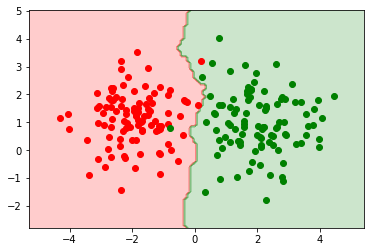

In [9]:
cmap = ListedColormap(["red","green"])
Z = np.array(Z).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
plt.scatter(*A, c='red')
plt.scatter(*B, c='green')
plt.show()

## Implementación con `scikit-learn`

Ahora que entendemos mejor el algoritmo del clasificador de kNN, usemos la implementación de sklearn que se encuentra optimizada.

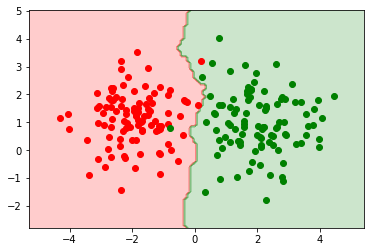

Wall time: 2.93 s


In [10]:
%%time
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5, 
                             weights='uniform',
                             algorithm='brute'
                             )
etiquetas = np.array([0]*100+[1]*100)
neigh.fit(data, etiquetas)
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
cmap = ListedColormap(["red","green"])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
plt.scatter(*A, c='red')
plt.scatter(*B, c='green')
plt.show()

Como podemos ver, obtenemos lo mismo con un factor de al menos 15 veces de ganancia en tiempo de ejecución. Moraleja: Siempre que puedan, usen scikit learn antes de programar sus propias rutinas. 

## Validación cruzada

En el ejemplo anterior, hemos fijado el valor de k arbitrariamente. El procedimiento habitual para definir el valor de $k$ en un clasificador kNN es realizar una validación cruzada para encontrar el $k$ óptimo. La validación cruzada puede ser del tipo $k'$-fold (tener en cuenta el nombre validación cruzada $k$-fold es usado, pero esta $k'$ es distinta a la $k$ de kNN), donde se divide $k'$ veces el conjunto de datos en dos: una parte de entrenamiento y otra de prueba y se evalua la exactitud del clasificador en cada repetición. Luego se calcula la exactitud global al promediar la exactitud de cada una de las $k'$ repeticiones (folds). Esto se realiza para distintos valores de vecinos $k$ y se elige el valor de $k$ que maximiza la exactitud promedio del clasificador. Vamos a realizar este procedimiento a continuación: 

In [11]:
data.shape

(200, 2)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [13]:
%%time
num_folds = 5
valores_de_k = np.arange(1,16,1)

avg_acc_vals = []
for k in valores_de_k:
    fold_accuracies = []
    for i in range(num_folds):
        X_train, X_test, y_train, y_test = train_test_split(data, etiquetas, test_size=0.2, random_state=42)
        
        neigh = KNeighborsClassifier(n_neighbors=k, 
                             weights='uniform',
                             algorithm='brute'
                             )
        
        neigh.fit(X_train, y_train)
        
        y_pred = neigh.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        
        fold_accuracies.append(acc)

    mean_acc = np.mean(fold_accuracies)

    avg_acc_vals.append((k, mean_acc))        
        

Wall time: 371 ms


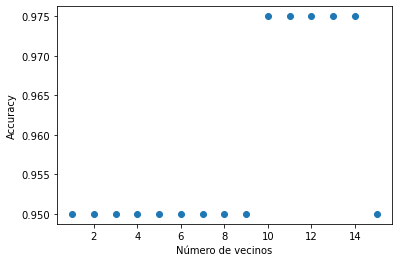

In [14]:
plt.scatter(*np.array(avg_acc_vals).T)
plt.xlabel('Número de vecinos')
plt.ylabel('Accuracy')
plt.show()

Vemos que hay ciertos valores de números de vecinos convenientes, ya que aumentan la exactitud del clasificador en la etapa de validación cruzada. Teniendo esto en cuenta, podemos quedarnos con $k=10$, como muestro a continuación. Mediante validación cruzada hemos "tuneado" u optimizado el hiperparámetro del método kNN.

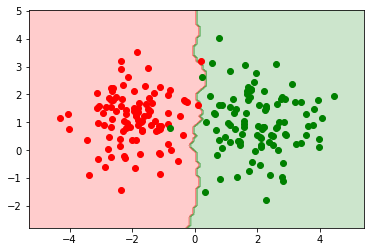

In [15]:
from sklearn.neighbors import KNeighborsClassifier

k = 10
neigh = KNeighborsClassifier(n_neighbors=k, 
                             weights='uniform',
                             algorithm='brute'
                             )
etiquetas = np.array([0]*100+[1]*100)
neigh.fit(data, etiquetas)
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
cmap = ListedColormap(["red","green"])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.2)
plt.scatter(*A, c='red')
plt.scatter(*B, c='green')
plt.show()

# Bibliografía y recursos útiles:

- [Documentación KNeighborsClassifier en sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

- [Gráfico de fronteras de decisión en kNN (sklearn)](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py)